# Using NLTK to process reviews of beer to classify as "ipa-like", which is a proxy for hoppiness or "not ipa-like", which is a proxy for maltiness

In [1]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
%matplotlib inline
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import nltk
import numpy
import random

In [2]:
def main():
    ## Put stuff in notebook here
    print "main!"

In [3]:
#In Python: Define a database name (we're using a dataset on births, so I call it 
# birth_db), and your username for your computer (CHANGE IT BELOW). 
dbname = 'beer_db_2'
username = 'postgres'
mypassword = 'simple'
engine = create_engine('postgres://%s:%s@localhost/%s'%(username,mypassword,dbname))

con = psycopg2.connect(database = dbname, user = username,host='/var/run/postgresql',password=mypassword)

# Queries

In [4]:
beer_style_query = '''
SELECT
    breweries.style_name,count(distinct breweries.beer_name) as number_of_beers
FROM
    breweries
GROUP BY
    breweries.style_name
ORDER BY
    number_of_beers desc;
'''
beer_style_rank = pd.read_sql_query(beer_style_query,con)

beer_reviews_query = '''
SELECT
    reviews.review_text,
    reviews.beer_key,
    reviews.username,
    reviews.look,
    reviews.taste,
    reviews.feel,
    reviews.overall,
    breweries.style_key,
    breweries.style_name
FROM 
    reviews,breweries
WHERE
    breweries.beer_name_key = reviews.beer_key
ORDER BY
    reviews.username
'''
beer_reviews = pd.read_sql_query(beer_reviews_query,con)

ratings_per_user_query = '''
SELECT
    reviews.username,count(reviews.review_text) as number_of_reviews
FROM 
    reviews,breweries
WHERE
    reviews.beer_key = breweries.beer_name_key
GROUP BY
    reviews.username
ORDER BY 
    number_of_reviews desc;
'''

user_ratings = pd.read_sql_query(ratings_per_user_query,con)

# IPA, Double IPA, English IPA
ipa_query = """
SELECT
    reviews.username,
    reviews.review_text,
    reviews.stemmed_review_text,
    reviews.beer_key,
    breweries.brewery_key,
    breweries.beer_name,
    reviews.look,
    reviews.taste,
    reviews.feel,
    reviews.overall,
    breweries.style_key,
    breweries.style_name
FROM 
    reviews,breweries
WHERE
    breweries.beer_name_key = reviews.beer_key
AND breweries.ratings_count > 5
AND 
( 
 breweries.style_key = 116
 OR breweries.style_key = 140
 OR breweries.style_key = 150
)
ORDER BY
    breweries.avg_score desc;
"""

# american porter, english porter, oatmeal stout, milk/sweet stout
not_ipa_query = """
SELECT
    reviews.username,
    reviews.review_text,
    reviews.stemmed_review_text,
    reviews.beer_key,
    breweries.brewery_key,
    breweries.beer_name,
    reviews.look,
    reviews.taste,
    reviews.feel,
    reviews.overall,
    breweries.style_key,
    breweries.style_name
FROM 
    reviews,breweries
WHERE
    breweries.beer_name_key = reviews.beer_key
AND breweries.ratings_count > 5
AND 
(
 breweries.style_key = 159
 OR breweries.style_key = 101
 OR breweries.style_key = 67
 OR breweries.style_key = 82
)
ORDER BY
    reviews.overall desc;
"""

# All Beers Except Hoppy or Dark Superstyles
all_beers_query = """
SELECT
    reviews.username,
    reviews.review_text,
    reviews.stemmed_review_text,
    reviews.beer_key,
    breweries.brewery_key,
    breweries.beer_name,
    reviews.look,
    reviews.taste,
    reviews.feel,
    reviews.overall,
    breweries.style_key,
    breweries.style_name
FROM 
    reviews,breweries
WHERE
    breweries.beer_name_key = reviews.beer_key
AND breweries.ratings_count > 0
ORDER BY
    reviews.overall desc;
"""
untrained_beers_query = """
SELECT
    reviews.username,
    reviews.review_text,
    reviews.stemmed_review_text,
    reviews.beer_key,
    breweries.brewery_key,
    breweries.beer_name,
    reviews.look,
    reviews.taste,
    reviews.feel,
    reviews.overall,
    breweries.style_key,
    breweries.style_name
FROM 
    reviews,breweries
WHERE
    breweries.beer_name_key = reviews.beer_key
AND breweries.ratings_count > 0
AND
(
 breweries.style_key != 159
 AND breweries.style_key != 101
 AND breweries.style_key != 67
 AND breweries.style_key != 82
 AND breweries.style_key != 116
 AND breweries.style_key != 140
 AND breweries.style_key != 150
)
ORDER BY
    reviews.overall desc;
"""

# Extracting Data From the Queries

In [5]:
ipa = pd.read_sql_query(ipa_query,con)
not_ipa = pd.read_sql_query(not_ipa_query,con)
all_beers = pd.read_sql_query(all_beers_query,con)

In [6]:
print 'ipa reviews:',ipa.shape[0]
print 'not_ipa reviews:',not_ipa.shape[0]
print 'all reviews:',all_beers.shape[0]

ipa reviews: 7557
not_ipa reviews: 1471
all reviews: 33827


In [7]:
# Put this stuff into a form that nltk can use
beer_reviews = []
hoppy_reviews = []
malty_reviews = []
all_beer_reviews = []

all_words = []
hoppy_words = []
malty_words = []
counter = 0

# choose whether to use stemmed_review_text or review_text
#which_review = 'stemmed_review_text'
which_review = 'review_text'

for beer in all_beers.iterrows():
    try:
        review_words = row[which_review].split()
        all_beer_reviews.append(review_words)
    except:
        "skipping, no review data"
print "extracted",len(all_beer_reviews)

for index,row in ipa.iterrows():
    try:
        review_words = row[which_review].split()
        beer_reviews.append((review_words,"ipa"))
        hoppy_reviews.append((review_words,"ipa"))
        for w in review_words:
            all_words.append(w.lower())
            hoppy_words.append(w.lower())
        counter += 1
        if counter == 500:
            print counter,"hoppy reviews gotten"
            break
    except:
        "skipping, no review data" 

counter = 0

for index,row in not_ipa.iterrows():
    try:
        review_words = row[which_review].split()
        beer_reviews.append((review_words,"not_ipa"))
        malty_reviews.append((review_words,"not_ipa"))
        for w in review_words:
            all_words.append(w.lower())
            malty_words.append(w.lower())
        counter += 1
        if counter == 500:
            print counter,"malty top reviews gotten"
            break
    except:
        "skipping, no review data"
print "got",len(beer_reviews),'reviews, with',len(all_words),'words.'

extracted 0
500 hoppy reviews gotten
500 malty top reviews gotten
got 1000 reviews, with 64001 words.


In [8]:
random.shuffle(beer_reviews)

# Compile Words

Here, we can get the frequency distribution of keywords, which are not stemmed.

In [9]:
all_words = nltk.FreqDist(all_words)
hoppy_words = nltk.FreqDist(hoppy_words)
malty_words = nltk.FreqDist(malty_words)
print "Hoppy Words:",hoppy_words.most_common(30),"\n"
print "Malty Words:",malty_words.most_common(30),"\n"
print "All words:",all_words.most_common(30),"\n"

Hoppy Words: [('i', 773), ('hops', 311), ('the', 310), ('citrus', 302), ('ipa', 278), ('taste', 274), ('hop', 263), ('head', 256), ('orange', 247), ('tropical', 238), ('good', 212), ('grapefruit', 209), ('like', 203), ('malt', 194), ('a', 194), ('fruit', 192), ('pine', 189), ('white', 181), ('nice', 181), ('one', 177), ('this', 172), ('light', 171), ('finish', 169), ('great', 167), ('flavor', 162), ('bitterness', 161), ('aroma', 159), ('carbonation', 155), ('well', 154), ('medium', 152)] 

Malty Words: [('i', 659), ('coffee', 649), ('chocolate', 509), ('dark', 470), ('the', 405), ('head', 374), ('porter', 308), ('taste', 298), ('roasted', 282), ('black', 279), ('like', 271), ('nice', 269), ('flavor', 227), ('malt', 222), ('a', 222), ('one', 219), ('light', 218), ('vanilla', 218), ('good', 213), ('brown', 207), ('well', 199), ('this', 185), ('sweet', 181), ('smooth', 180), ('great', 169), ('medium', 165), ('creamy', 165), ('bit', 165), ('finish', 160), ('it', 154)] 

All words: [('i', 1

# Create sparse vectors of words for bayesian classificaiton

In [10]:
word_features = list(all_words.keys())[:3000]

def find_features(beer_review):
    words = set(beer_review)
    features = {}
    for w in word_features:
        features[w] = (w in words) # boolean assignment
    return features
print find_features(malty_reviews[0][0])

{'clamoring': False, 'desirable': False, 'swirls': False, 'yellow': False, 'four': False, 'maltier': False, 'woods': False, 'hanging': False, 'ringlets': False, 'woody': False, 'centimeter': False, 'worked': False, 'adorning': False, 'payoff': False, 'increase': False, 'quaffable': False, 'canes': False, 'buddy': False, 'quadruple': False, 'tickle': False, 'tingle': False, 'swap': False, 'lord': False, 'gracious': False, 'worth': False, 'deli': False, 'blanket': False, 'manic': False, 'expierences': False, 'figs': False, 'bringing': False, 'caramels': False, 'basics': False, 'daydream': False, 'caramely': False, 'pinch': False, 'specialties': False, 'differentiates': False, 'nondescript': False, 'shows': False, 'whirlwind': False, 'chew': False, 'specially': False, 'tired': False, 'blasphemy': False, 'companyalpine': False, 'preface': False, 'bacon': False, 'elegant': False, 'second': False, 'glassl': False, 'rigorous': False, 'glassa': False, 'beigebrown': False, 'lucious': False, 'fi

In [11]:
featuresets = [(find_features(rev),category) for (rev,category) in beer_reviews]
training_set = featuresets[:500]
testing_set = featuresets[500:]

# Bayes Classifier

## Train the classifier

In [12]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

## Run the classifier on the testing set, determine accuracy

In [13]:
print "Naive Bayes Algo % accuracy:",(nltk.classify.accuracy(classifier,testing_set))*100.
classifier.show_most_informative_features(30)

Naive Bayes Algo % accuracy: 95.0
Most Informative Features
                  coffee = True           not_ip : ipa    =     95.0 : 1.0
                 roasted = True           not_ip : ipa    =     62.6 : 1.0
                   brown = True           not_ip : ipa    =     58.8 : 1.0
              grapefruit = True              ipa : not_ip =     50.7 : 1.0
                  roasty = True           not_ip : ipa    =     24.5 : 1.0
                     ipa = True              ipa : not_ip =     17.5 : 1.0
                   mocha = True           not_ip : ipa    =     16.2 : 1.0
                    dark = True           not_ip : ipa    =     14.3 : 1.0
                  barrel = True           not_ip : ipa    =     13.0 : 1.0
                  golden = True              ipa : not_ip =     12.9 : 1.0
                    gold = True              ipa : not_ip =     10.3 : 1.0
                  bright = True              ipa : not_ip =      9.9 : 1.0
                   piney = True         

## Now, we can classify individual beers using the bayesean classifier

In [14]:
def get_hoppy_probabilities(feature_set):
    prob = {}
    dist = classifier.prob_classify(feature_set)
    for label in dist.samples():
        prob[label] = dist.prob(label)
    return prob

In [15]:
print classifier.prob_classify(find_features(malty_reviews[0][0]))
print classifier.classify(find_features(malty_reviews[0][0]))

#probs = get_hoppy_probabilities(test_features)
#print probs["ipa"],probs["not_ipa"]

# for review in malty_reviews:
#     dist = classifier.prob_classify(find_features(review[0]))
#     for label in dist.samples():
#         print("%s: %f" % (label, dist.prob(label)))

<ProbDist with 2 samples>
not_ipa


In [16]:
rows_list = []
index_out = 0
for index,row in all_beers.iterrows():
    #print index
    #print row
    try:
        features = find_features(row['review_text'].split())
    except:
        continue
    hoppiness = get_hoppy_probabilities(features)
    #print hoppiness
    
    out_dict = {}
    out_dict['beer_key'] = row['beer_key']
    out_dict['username'] = row['username']
    out_dict['review_text'] = row['review_text']
    out_dict['name'] = row['beer_name']
    out_dict['style'] = row['style_name']
    out_dict['hoppiness'] = hoppiness['ipa']
    out_dict['maltiness'] = hoppiness['not_ipa']
    out_dict['hop_liklihood'] = hoppiness['ipa']/(hoppiness['ipa']+hoppiness['not_ipa'])
    rows_list.append(out_dict)
    #print rows_list

In [17]:
classified_df = pd.DataFrame(rows_list)

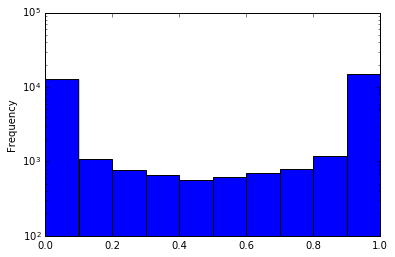

In [18]:
classified_df['hoppiness'].plot(kind='hist',logy=True)

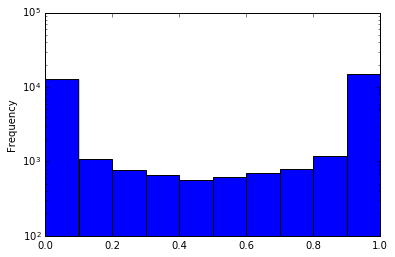

In [19]:
classified_df['hop_liklihood'].plot(kind='hist',logy=True)

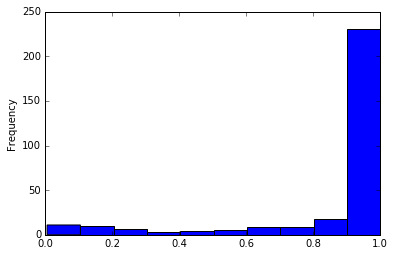

In [20]:
classified_df['hoppiness'][classified_df['style']=='Kölsch'].plot(kind='hist')

In [21]:
#classified_df.sort(['maltiness'],ascending=0)

In [27]:
classified_beers = []
classified_df.to_csv("test.csv")
